In [15]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from numba import cuda

cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3050 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 2
                                    UUID: GPU-323511ec-5724-7c5a-0b57-4705dd18bf49
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

Функция поиска подстрок на CPU

In [2]:
def mass_search_CPU(N: np.ndarray, H: np.ndarray, R: np.ndarray):
  for j in range(R.shape[1]):
    for i in range(R.shape[0]):
      n = N[i]
      for k in range(len(n)):
        if n[k] == H[j]:
          R[i, j - k] -= 1
  return R

Функция поиска подстрок на GPU

In [3]:
@cuda.jit
def mass_search_GPU(N: np.ndarray, H: np.ndarray, R: np.ndarray):
	# Получение асболютного значения индекса потока в сетке
	x, y = cuda.grid(2)
	# Рассматриваем каждый символ подстроки
	n = N[y]
	for k in range(len(n)):
		# Декремент, если символ подстроки совпал с символом входного буффера
		if n[k] == H[x]:
			R[y, x - k] -= 1
	cuda.syncthreads()

Запись входных данных (N и H) в файл

In [4]:
def save_input(pathfile: str, N: np.ndarray, H: np.ndarray, mode='a', sheet_name=''):

  # Приведение списка символов (подстроки) к типу str
  # для корректной записи в excel
  new_N = [str(n) for n in N]
  
  # Создание DataFrame
  df = pd.DataFrame({"N": new_N, "H": H})
  
  # Если стоит mode='a', то первая запись в файл выдаст ошибку,
  # поэтому в этом случае mode меняется на 'w'.
  try:
    with pd.ExcelWriter(pathfile, mode=mode) as writer:
      df.to_excel(writer, sheet_name=sheet_name)
  except:
    with pd.ExcelWriter(pathfile, mode='w') as writer:
      df.to_excel(writer, sheet_name=sheet_name)

Запись рабочей матрицы R в файл

In [5]:
def save_R(pathfile: str, result: np.ndarray, mode='a'):

  df = pd.DataFrame(result)

  sheet_name = str(len(N))
  
  try:
    with pd.ExcelWriter(pathfile, mode=mode) as writer:
      df.to_excel(writer, sheet_name=sheet_name)
  except:
    with pd.ExcelWriter(pathfile, mode='w') as writer:
      df.to_excel(writer, sheet_name=sheet_name)

Вычисления на CPU и GPU i раз для усреднения времени

In [6]:
sizes = np.arange(150, 1800, 150)  # Размерности N и H
i = 8                            # Кол-во итераций для подсчёта среднего времени
N_chars = 2                       # Кол-во символов в подстроках
BLOCK_DIM = 32                    # Размерность оси квадратного блока
BLOCK_SIZE = (BLOCK_DIM, BLOCK_DIM)

alp = np.arange(256)

df = {"Время на GPU":np.zeros(len(sizes), dtype=float), 
      "Время на CPU":np.zeros(len(sizes), dtype=float),
      "Ускорения":np.zeros(len(sizes), dtype=float),
      "Одинаковые ли значения?":np.full(len(sizes), fill_value=True)}

df = pd.DataFrame(df, index=sizes)

In [7]:
# Вычисления для разных размерностей N и H
for size in sizes:

  # Случайная генерация подстрок N и входного буффера H
  N = np.random.randint(len(alp), size=(size, N_chars), dtype=np.uint8)
  H = np.random.randint(len(alp), size=size, dtype=np.uint8)

  # Заполнение рабочей матрицы NxH значениями N_chars
  R = np.full((size, size), fill_value=N_chars)

  # Инициализация сетки блоков
  GRID_SIZE = ((len(N) + BLOCK_DIM - 1) // BLOCK_DIM , (len(H) + BLOCK_DIM - 1) // BLOCK_DIM)

  # Суммы общего времени за определённое кол-во итераций для реализации
  gpu_common_time = []
  cpu_common_time = []

  # Выполнение одних и тех же вычислений для нахождения среднего времени
  for i in range (i + 1):

    #Вычисление времени на GPU
    start_time = time()
    
    # Пересылка данных на устройство
    dev_N = cuda.to_device(N)
    dev_H = cuda.to_device(H)
    dev_R = cuda.to_device(R)
    
    # Запуск вычислений на GPU
    mass_search_GPU[GRID_SIZE, BLOCK_SIZE](dev_N, dev_H, dev_R)

    # Копирование рабочей матрицы с устройства на хост
    host_R = dev_R.copy_to_host()
    gpu_common_time.append(time() - start_time)

    #Вычисление времени на CPU
    start_time = time()
    R = mass_search_CPU(N, H, R.copy())
    cpu_common_time.append(time() - start_time)

    if i == 0:
      save_R("R_GPU.xlsx", host_R)
      save_R("R_CPU.xlsx", R)
  
  # Запись подсчётов времени и соответствия рабочих матриц
  df.loc[size, "Время на GPU"] = np.mean(gpu_common_time[0:])
  df.loc[size, "Время на CPU"] = np.mean(cpu_common_time[0:])
  df.loc[size, "Одинаковые ли значения?"] = np.array_equal(host_R, R)


  # Сохранение входных данных в файл с несколькими листами
  save_input("input_data.xlsx", N, H, sheet_name=f'Размер {size}')

c:\Users\Bogda\anaconda3\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (25) < 2 * SM count (32) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\Bogda\anaconda3\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (25) < 2 * SM count (32) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Text(0, 0.5, 'Ускорение')

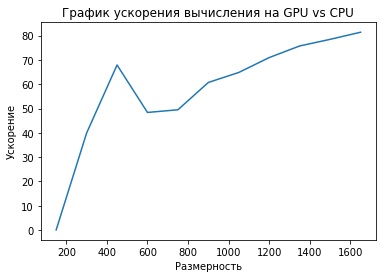

In [10]:
# Запись значений ускорения GPU над CPU
df["Ускорения"] = df["Время на CPU"] / df["Время на GPU"]

plt.plot(df["Ускорения"])
plt.title("График ускорения вычисления на GPU vs CPU")
plt.xlabel("Размерность")
plt.ylabel("Ускорение")

In [ ]:
df
print("Значительный прирост скорости обработки данных возникает уже при длине подстрок более 150")
print("При выполнении алгоритмов на CPU и GPU практически всегда выдаются одинаковые значения для работы алгоритма поиска подстроки")

,Время на GPU,Время на CPU,Ускорения,Одинаковые ли значения?,Ускорение
160,0.188960,0.017065,0.090312,True,0.090312
320,0.001774,0.074117,41.773665,True,41.773665
480,0.002659,0.156807,58.965563,True,58.965563
640,0.005642,0.267520,47.414353,True,47.414353
800,0.007536,0.435159,57.747439,True,57.747439
960,0.009548,0.605496,63.416023,True,63.416023
1120,0.011962,0.819835,68.534419,True,68.534419
1280,0.015439,1.146174,74.241156,True,74.241156
1440,0.018181,1.394463,76.698547,False,76.698547
